In [1]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import src.utils as utils
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from src.getDensity import getFilteredDensity
import src.utils as utils
import pickle
from scipy.io import savemat

Model type:  <class 'sklearn.linear_model._base.LinearRegression'>
Mean test error:  30.043760485464965


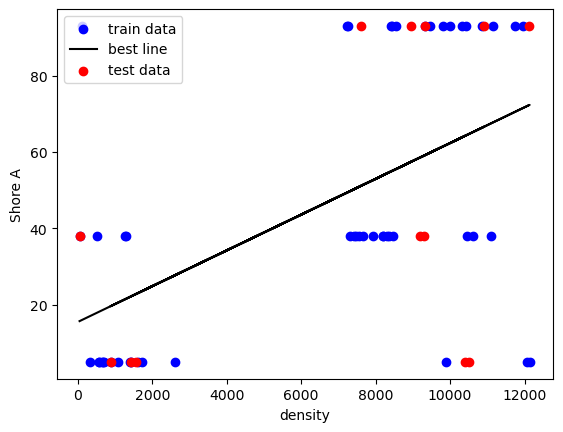

In [2]:
if __name__ == "__main__":
    path = "flowdata2"
    exportPath = os.path.join("data", "densityResult")
    feature = "raw"
    if feature == "raw":
        regressor = LinearRegression()
    else:
        regressor = MLPRegressor(hidden_layer_sizes=(
            100,
            100,
            100,
            10,
            10,
        ),
                                 early_stopping=True,
                                 max_iter=500)
    
    total_densityList = []
    total_YoungsList = []
    total_SList = []

    densityList = []
    YoungsList = []
    SList = []

    S = 0

    flow_file_list = sorted(glob.glob(
            os.path.join(path,"*.npy")))
    h, w, _ = np.load(flow_file_list[0]).shape
    croppedShape = (min(h, w), min(h, w))
    x = np.linspace(0.0,
                        croppedShape[1] - 30,
                        croppedShape[1] - 30,
                        endpoint=False)
    y = np.linspace(0.0,
                        croppedShape[0] - 30,
                        croppedShape[0] - 30,
                        endpoint=False)
    axis = np.array(np.meshgrid(x, y)).transpose((1, 2, 0))

    for i in range(len(flow_file_list)):
        flow = np.load(flow_file_list[i])
           
            
        density, zero_level = getFilteredDensity(flow, use_cuda=True)
        # remapping
        density = (density + 1.0) / 1.0
        density = (density * 255.0).astype('uint8')

        density = density[15:-15,15:-15]



        threshold, contact_boundary = utils.getContactBoundary(density)
        #density[np.where(density < threshold)] = 0
        """
        if i//10 == 0:
            density1 = cv2.applyColorMap(density, cv2.COLORMAP_HOT)
            cv2.imshow("density",contact_boundary)
            cv2.waitKey(1000)
            cv2.destroyAllWindows()
        """
        temp = density.flatten()
        temp = temp[temp>=10]

        S = len(temp)

        SList.append(S)
        densityList.append(density.max())

        if i>=0 and i<=20:
            YoungsList.append(93)
        elif i>=21 and i<=41:
            YoungsList.append(38)
        else:
            YoungsList.append(5)
        
    total_densityList.extend(densityList)
    total_YoungsList.extend(YoungsList)
    total_SList.extend(SList)

    X_1 = np.array(total_densityList)
    X_2 = np.array(total_SList)
    Y = np.array(total_YoungsList)

    X_train, X_test, y_train, y_test = train_test_split(X_2,
                                                        Y,
                                                        test_size=0.2,
                                                        random_state=42)    
    X_train.resize(len(X_train),1)
    X_test.resize(len(X_test),1)
    regressor.fit(X_train, y_train)
    print("Model type: ", type(regressor))
    print("Mean test error: ",
          np.abs(regressor.predict(X_test) - y_test).mean())
    #print(regressor.coef_, regressor.intercept_)
    
    plt.scatter(X_train,y_train,color='b',label='train data')
    test_y_pred=regressor.predict(X_test)
    plt.plot(X_test,test_y_pred,color='black',label='best line')
#测试集数据的散点图
    plt.scatter(X_test,y_test,color='r',label='test data')
#坐标轴
    plt.xlabel('density')
    plt.ylabel('Shore A')
    plt.legend(loc=2)
    plt.show()

In [60]:
test = np.load(flow_file_list[43])
img = cv2.imread("./pic_raw2/pic-0.jpg")
vis = utils.flowvis(img[20:-20,20:-20],test[20:-20,20:-20])
cv2.imshow("vis", vis)
cv2.waitKey(1000)
cv2.destroyAllWindows()

In [61]:

mag, ang = cv2.cartToPolar(test[..., 0], test[..., 1])#将直角坐标系光流场转成极坐标系

hsv = np.zeros((test.shape[0], test.shape[1], 3), np.uint8)

#光流可视化的颜色模式

hsv[..., 0] = ang * 180 / np.pi / 2 #angle弧度转角度
hsv[..., 1] = 255
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)#magnitude归到0～255之间

v = hsv[...,2]
v.mean()



34.41579545454545